### Импортируем нужные библиотеки

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Загрузим датасет

In [2]:
df = pd.read_csv("S02-hw-dataset.csv", sep=',')
df.head(10)

,user_id,age,country,purchases,revenue
0,1,25.0,FR,7,749
1,2,24.0,RU,5,1115
2,3,52.0,FR,7,399
3,4,31.0,RU,6,654
4,5,NaN,DE,6,1296
5,6,120.0,FR,-1,785
6,7,46.0,RU,0,0
7,8,28.0,CN,2,456
8,9,39.0,US,4,980
9,10,24.0,RU,7,511


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   user_id    41 non-null     int64  
 1   age        39 non-null     float64
 2   country    41 non-null     object 
 3   purchases  41 non-null     int64  
 4   revenue    41 non-null     int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 1.7+ KB


In [4]:
df.describe()

,user_id,age,purchases,revenue
count,41.000000,39.000000,41.000000,41.000000
mean,20.243902,36.512821,4.829268,820.048780
std,11.659289,18.304259,2.710189,613.127269
min,1.000000,5.000000,-1.000000,0.000000
25%,10.000000,24.000000,3.000000,432.000000
50%,20.000000,33.000000,5.000000,693.000000
75%,30.000000,45.500000,7.000000,1115.000000
max,40.000000,120.000000,11.000000,2475.000000


### Проверим пропуски, дубликаты и выполним базовый контроль качества

In [5]:
for col in df.columns:
    print(f"Mean NaN for {col}:", df[col].isna().mean())

Mean NaN for user_id: 0.0
Mean NaN for age: 0.04878048780487805
Mean NaN for country: 0.0
Mean NaN for purchases: 0.0
Mean NaN for revenue: 0.0


In [6]:
df['user_id'].duplicated().sum()

np.int64(1)

In [7]:
df.duplicated().sum()

np.int64(1)

In [8]:
df.duplicated(subset=[col for col in df.columns if col != 'id']).sum() # Посмотрим, есть ли дубликаты у строк с уникальными id

np.int64(1)

In [9]:
df["age"].describe()

count     39.000000
mean      36.512821
std       18.304259
min        5.000000
25%       24.000000
50%       33.000000
75%       45.500000
max      120.000000
Name: age, dtype: float64

In [10]:
df[(pd.to_numeric(df["age"], errors='coerce') < 14) | # Не будем выбирать минимальный возраст 0 и предположим, что человек может соверщать покупки с 14 лет (ну точно не с 5 и ниже) 
(pd.to_numeric(df["age"], errors='coerce') > 100)].shape[0]

2

In [11]:
df[(pd.to_numeric(df["age"], errors='coerce') < 14) |
(pd.to_numeric(df["age"], errors='coerce') > 100)]

,user_id,age,country,purchases,revenue
5,6,120.0,FR,-1,785
20,21,5.0,RU,8,1488


In [12]:
df['country'].unique() # Есть ли аномалии в странах

array(['FR', 'RU', 'DE', 'CN', 'US'], dtype=object)

In [13]:
df[(pd.to_numeric(df["purchases"], errors='coerce') < 0)].shape[0]

1

In [14]:
df[(pd.to_numeric(df["purchases"], errors='coerce') < 0)]

,user_id,age,country,purchases,revenue
5,6,120.0,FR,-1,785


In [15]:
df[(pd.to_numeric(df["purchases"], errors='coerce') <= 0) &
(pd.to_numeric(df["revenue"], errors='coerce') > 0)].shape[0] # Есть ли доход без покупки

1

In [16]:
df[(pd.to_numeric(df["purchases"], errors='coerce') <= 0) &
(pd.to_numeric(df["revenue"], errors='coerce') > 0)]

,user_id,age,country,purchases,revenue
5,6,120.0,FR,-1,785


In [17]:
df[(pd.to_numeric(df["purchases"], errors='coerce') > 0) &
(pd.to_numeric(df["revenue"], errors='coerce') <= 0)].shape[0] # Есть ли покупки без дохода

1

In [18]:
df[(pd.to_numeric(df["purchases"], errors='coerce') > 0) &
(pd.to_numeric(df["revenue"], errors='coerce') <= 0)]

,user_id,age,country,purchases,revenue
10,11,24.0,US,4,0


In [19]:
df["revenue"].describe()

count      41.000000
mean      820.048780
std       613.127269
min         0.000000
25%       432.000000
50%       693.000000
75%      1115.000000
max      2475.000000
Name: revenue, dtype: float64

В датасете есть немного пропущенных значений и дубликатов. В колонке возраста были найдены аномалии в виде двух категорически выделяюхихся возрастов 5 и 120. Были найдены аномальные значения в колонке покупок (количество < 0). Также были найдены строки в которых из покупки не было полученно какого-либо дохода.

### Базовый EDA: группировки, агрегаты и частоты

In [20]:
df['country'].value_counts()

country
RU    13
FR    12
US     8
DE     6
CN     2
Name: count, dtype: int64

Посчитаем среднее количество покупок по странам 

In [21]:
df[pd.to_numeric(df["purchases"], errors='coerce') >= 0].groupby('country')['purchases'].mean()

country
CN    4.500000
DE    6.500000
FR    4.727273
RU    4.769231
US    4.625000
Name: purchases, dtype: float64

Посчитаем общую сумму дохода по странам

In [22]:
df[pd.to_numeric(df["revenue"], errors='coerce') > 0].groupby('country')['revenue'].sum()

country
CN     2108
DE     8673
FR     8111
RU    10271
US     4459
Name: revenue, dtype: int64

Посчитаем средний возраст по странам (с учетом аномальных значений) 

In [23]:
df[(pd.to_numeric(df["age"], errors='coerce') >= 14) &
(pd.to_numeric(df["age"], errors='coerce') <= 100)].groupby('country')['age'].mean()

country
CN    24.000000
DE    34.600000
FR    39.545455
RU    32.166667
US    36.714286
Name: age, dtype: float64

В доминирующих категорий выделяются RU и FR. В среднем, больше всего покупок делали из DE и меньше - из CN, и больший доход был получен из RU и меньший - из US. По среднему возрасту можно сказать, что FR - обладательница самых старых покупателей, а CN - самых молодых.

### Визуализация данных в Matplotlib

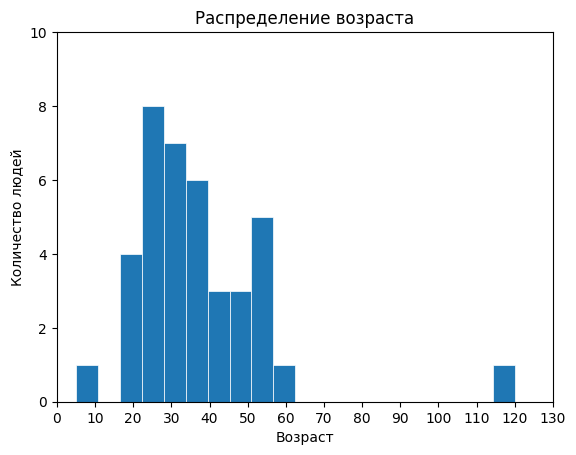

In [24]:
fig, ax = plt.subplots()
ax.hist(df['age'], bins=20, linewidth=0.5, edgecolor="white")
ax.set(xlim=(0, 130), xticks=np.arange(0, 131, 10),
       ylim=(0, 10))

plt.xlabel("Возраст")
plt.ylabel("Количество людей")
plt.title("Распределение возраста")
plt.savefig("figures/age_distribution.png")
plt.show()

Данный график показывает распределение возрастов. По нему можно определить выбросы и люди какого возраста чаще всего приобретают что-то 

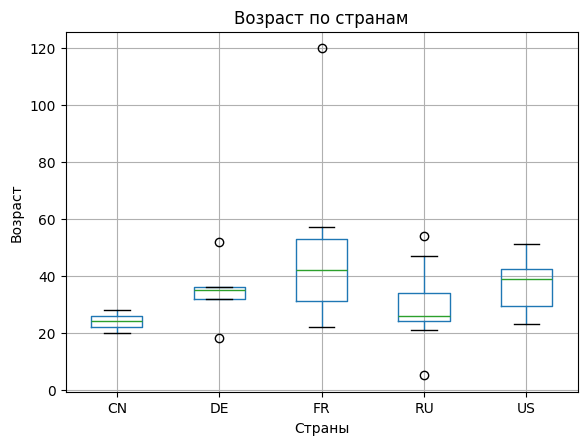

In [25]:
fig, ax = plt.subplots()
df.boxplot(column='age', by='country', ax=ax)

plt.xlabel("Страны")
plt.ylabel("Возраст")
plt.title("Возраст по странам")
plt.suptitle("")
plt.savefig("figures/age_by_country.png")
plt.show()

Данный график показывает распределения и концетрации возрастов по странам. По нему можно определить выбросы и распределения возрастов для отдельной страны.

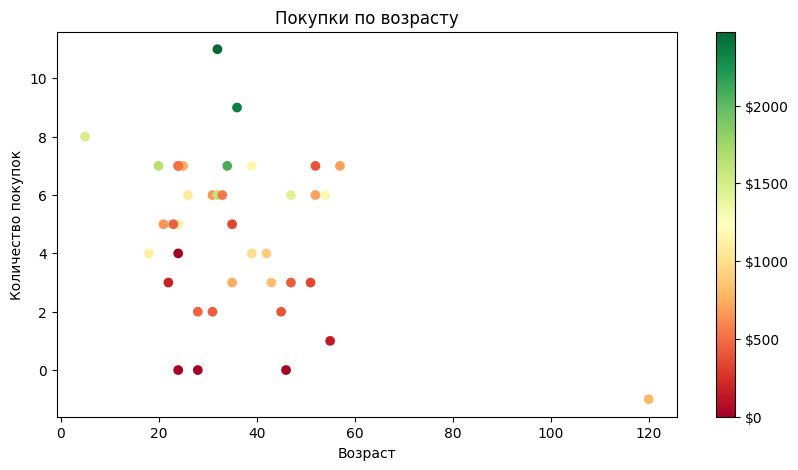

In [26]:
plt.figure(figsize=(10, 5))
scatter = plt.scatter(df['age'], df['purchases'], c=df['revenue'],  cmap="RdYlGn")
plt.colorbar(scatter, format="$%d") # Пусть будут доллары)
plt.xlabel("Возраст")
plt.ylabel("Количество покупок")
plt.title("Покупки по возрасту")
plt.savefig("figures/purchase_by_age.png")
plt.show()

Данный график показывает количество покупок для каждого человека по возрасту и сколько было потрачено на покупки. По нему можно определить выбросы, отследить рост цены с увеличением количиства покупок, и кто сколько тратит по возростам.